In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit

from jupyterthemes import jtplot
jtplot.style(theme='onedork')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,6)

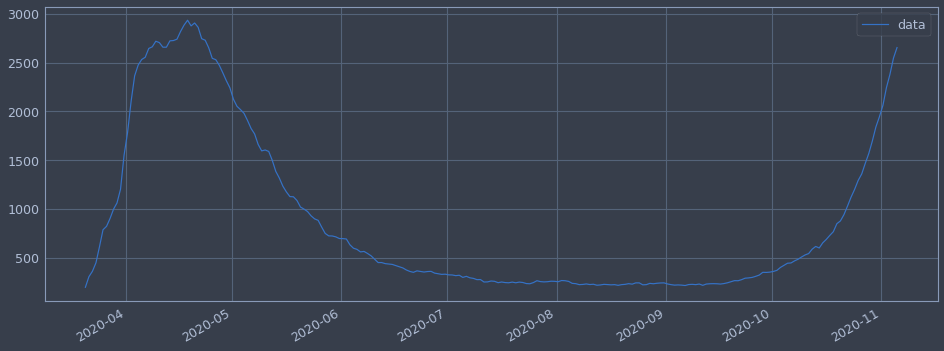

In [2]:
# data-source: https://datawrapper.dwcdn.net/WvhXR/

df_raw = pd.read_csv('data-WvhXR.csv', index_col=0, names=['data'], header = 0)
df_raw.index = pd.to_datetime(df_raw.index, utc=True)
df_raw.plot()

In [3]:
find_min_start = '2020-05'
find_min_end = '2020-10'

argmin = df_raw[(df_raw.index > find_min_start) & 
                (df_raw.index < find_min_end) & 
                (df_raw.data == df_raw.data[find_min_start:find_min_end].min())].index[0]

df_fit = df_raw[argmin:] # sadly this doesn't work later on
df_fit = df_raw[find_min_end:] # so I have to do this

In [4]:
def gaussian(x, sat, td, velo, offset):
    x = np.float64(x) / 1e18
    sat *= 1e4
    offset *= 1e4
    velo /=1e2

    return (sat * np.exp(-(x-td)**2/(2*velo**2))) + offset

<ipython-input-5-0b64d8706dd5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['fit'] = gaussian(df_fit.index, *list(popt))
<ipython-input-5-0b64d8706dd5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['res'] = df_fit.data - df_fit.fit


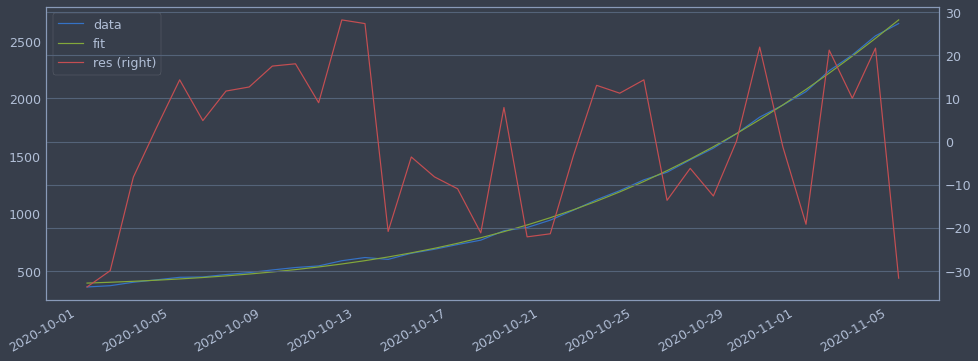

In [5]:
popt, pcov = curve_fit(
    f = gaussian,
    xdata = df_fit.index,
    ydata = df_fit.data,
    p0 = (1, 1.61, .3, 1)
)

df_fit['fit'] = gaussian(df_fit.index, *list(popt))
df_fit['res'] = df_fit.data - df_fit.fit

df_fit.plot(secondary_y="res")

In [6]:
maxdate = datetime.datetime.fromtimestamp(popt[1] * 1e9, tz=df_fit.index.tz)
maxdate.strftime("%Y-%B-%d %H:%M")

'2020-December-03 02:16'

In [7]:
int(popt[0] * 1e4)

6128

In [8]:
sigma = datetime.timedelta(seconds=(popt[2] / 1e2) * 1e9)
sigma

datetime.timedelta(days=19, seconds=75209, microseconds=269705)

In [9]:
maxdate - sigma

datetime.datetime(2020, 11, 13, 5, 23, 28, 129590, tzinfo=<UTC>)

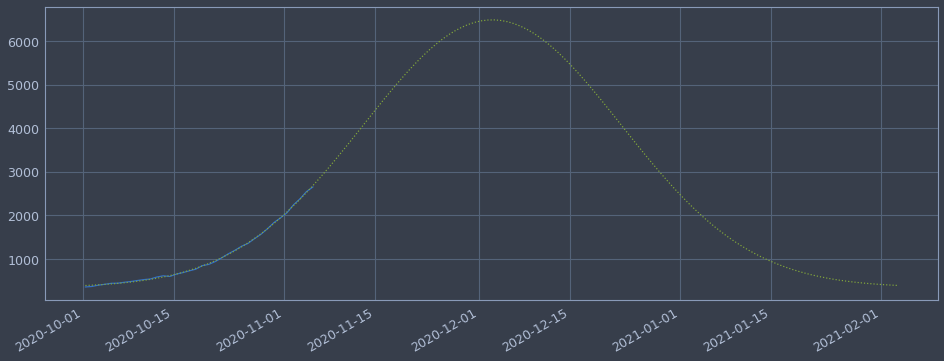

In [10]:
ix_extrapol = pd.date_range(df_fit.index[0], df_fit.index[0] + 2 *  (maxdate - df_fit.index[0]))

df_fit.data.plot()
pd.Series(gaussian(ix_extrapol, *list(popt)), index=ix_extrapol).plot(style=':')

In [11]:
ix_extrapol10 = pd.date_range(df_fit.index[-1] + datetime.timedelta(1), df_fit.index[-1] + datetime.timedelta(50))

pd.Series(gaussian(ix_extrapol10, *list(popt)), index=ix_extrapol10.date).astype(int)

2020-11-06    2850
2020-11-07    3021
2020-11-08    3196
2020-11-09    3375
2020-11-10    3558
2020-11-11    3742
2020-11-12    3929
2020-11-13    4116
2020-11-14    4302
2020-11-15    4488
2020-11-16    4671
2020-11-17    4851
2020-11-18    5027
2020-11-19    5197
2020-11-20    5361
2020-11-21    5517
2020-11-22    5665
2020-11-23    5803
2020-11-24    5930
2020-11-25    6046
2020-11-26    6150
2020-11-27    6240
2020-11-28    6317
2020-11-29    6380
2020-11-30    6428
2020-12-01    6461
2020-12-02    6478
2020-12-03    6480
2020-12-04    6467
2020-12-05    6438
2020-12-06    6394
2020-12-07    6335
2020-12-08    6261
2020-12-09    6174
2020-12-10    6074
2020-12-11    5961
2020-12-12    5836
2020-12-13    5701
2020-12-14    5555
2020-12-15    5401
2020-12-16    5239
2020-12-17    5071
2020-12-18    4896
2020-12-19    4717
2020-12-20    4534
2020-12-21    4349
2020-12-22    4163
2020-12-23    3976
2020-12-24    3789
2020-12-25    3604
dtype: int64